# Recursive Forecasting with Skforecast

**Notebook Contents**

* [EDA](#scrollTo=j7f1lYkg8nBP&line=1&uniqifier=1)
* [Data Splitting](#scrollTo=wUbAtjFGWjn8&line=1&uniqifier=1)
* [Feature Engineering](#scrollTo=SPLI4USHYM9s&line=1&uniqifier=1)
* [Model Fitting](#scrollTo=YXTfmmG5bcAe&line=1&uniqifier=1)
* [Basic Evaluation: Test Data](#scrollTo=6DfBACsqbtl-&line=1&uniqifier=1)
* [X & Y Training Matrices](#scrollTo=j-YixqTFhqR8&line=1&uniqifier=1)
* [Forecasting Future](#scrollTo=rz7HlXpbj8bT&line=7&uniqifier=1)
* [Feature Importance](#scrollTo=c-FUFRSp7ZoU&line=1&uniqifier=1)
* [Predicting Full Training Data](#scrollTo=3mRu6KDHyQjz&line=1&uniqifier=1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import lightgbm as lgb
import numpy as np

In [ ]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import ParameterGrid
import math
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [ ]:
!pip install skforecast

In [ ]:
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import plot_prediction_intervals, set_dark_theme

In [ ]:
!pip install feature-engine

In [ ]:
from feature_engine.datetime import DatetimeFeatures

# Load Retail Sales Data

In [ ]:
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"
df = pd.read_csv(url)
df.to_csv("example_retail_sales.csv", index=False)

df = pd.read_csv(
    "example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
    nrows=160,
)

df= df.asfreq("MS")

df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


In [ ]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2004-07-01', '2004-08-01', '2004-09-01', '2004-10-01',
               '2004-11-01', '2004-12-01', '2005-01-01', '2005-02-01',
               '2005-03-01', '2005-04-01'],
              dtype='datetime64[ns]', name='ds', length=160, freq='MS')

In [ ]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2004-07-01', '2004-08-01', '2004-09-01', '2004-10-01',
               '2004-11-01', '2004-12-01', '2005-01-01', '2005-02-01',
               '2005-03-01', '2005-04-01'],
              dtype='datetime64[ns]', name='ds', length=160, freq='MS')

In [ ]:
# check if any missing frequencies
import pandas as pd

# Suppose df has a DatetimeIndex at monthly frequency
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="MS")  # "MS" = month start
missing = full_range.difference(df.index)

print("Missing months:", missing)

Missing months: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


# EDA

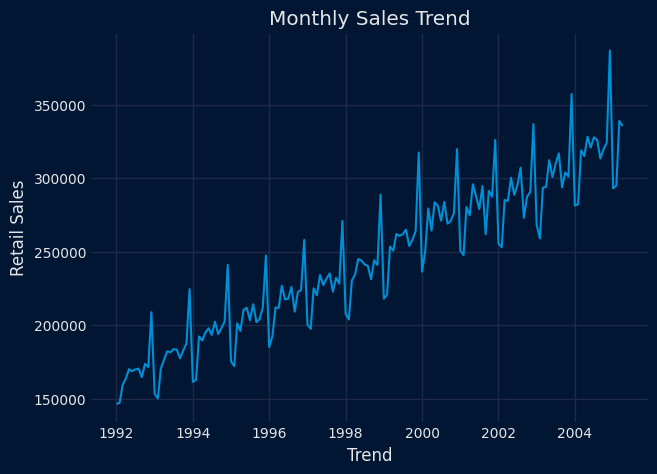

In [ ]:
set_dark_theme()
sns.lineplot(data=df, x=df.index, y="y");
# sns.relplot(data=df_date_line, x="Date", y="Revenue", kind="line")
plt.title('Monthly Sales Trend')
plt.xlabel('Trend')
plt.ylabel('Retail Sales')
plt.grid(True)

In [ ]:
df_quarter = df.resample("QE").mean()
df_quarter.head()

,y
ds,
1992-03-31,150930.333333
1992-06-30,167466.666667
1992-09-30,168290.333333
1992-12-31,184680.000000
1993-03-31,157915.666667


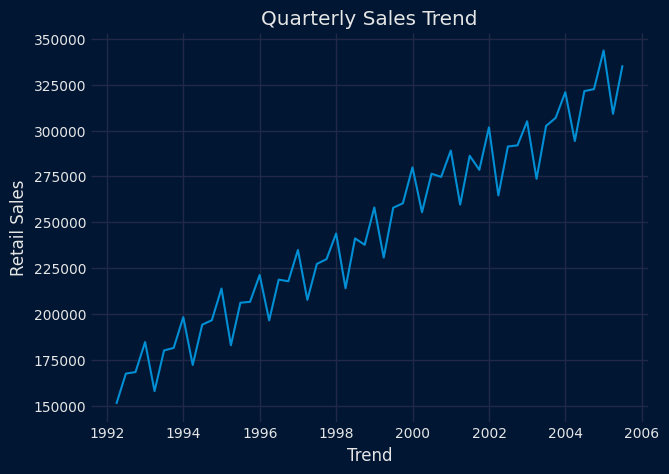

In [ ]:
sns.lineplot(data=df_quarter, x=df_quarter.index, y="y");
# sns.relplot(data=df_date_line, x="Date", y="Revenue", kind="line")
plt.title('Quarterly Sales Trend')
plt.xlabel('Trend')
plt.ylabel('Retail Sales')
plt.grid(True)

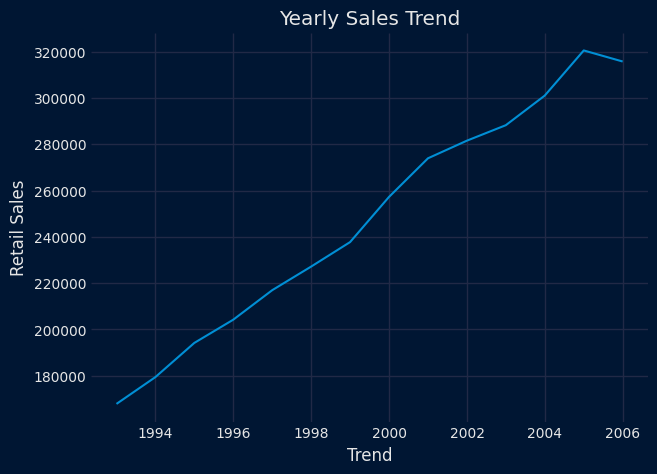

In [ ]:
df_year = df.resample("YE").mean()

sns.lineplot(data=df_year, x=df_year.index, y="y");
# sns.relplot(data=df_date_line, x="Date", y="Revenue", kind="line")
plt.title('Yearly Sales Trend')
plt.xlabel('Trend')
plt.ylabel('Retail Sales')
plt.grid(True)

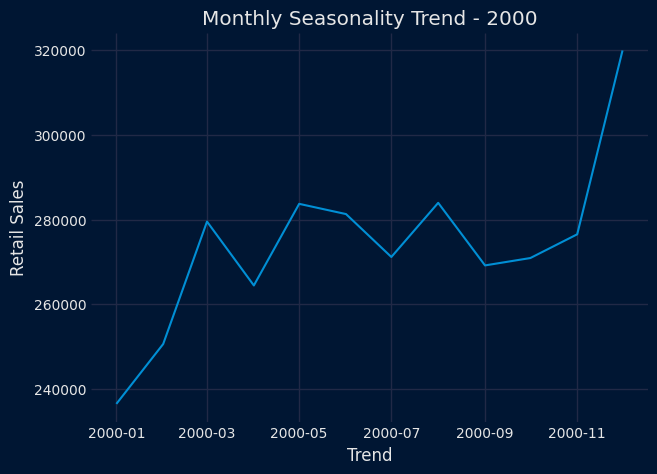

In [ ]:
year = '2000'
sns.lineplot(data=df.loc[year], x=df.loc[year].index, y="y");
# sns.relplot(data=df_date_line, x="Date", y="Revenue", kind="line")
plt.title(f'Monthly Seasonality Trend - {year}')
plt.xlabel('Trend')
plt.ylabel('Retail Sales')
plt.grid(True)

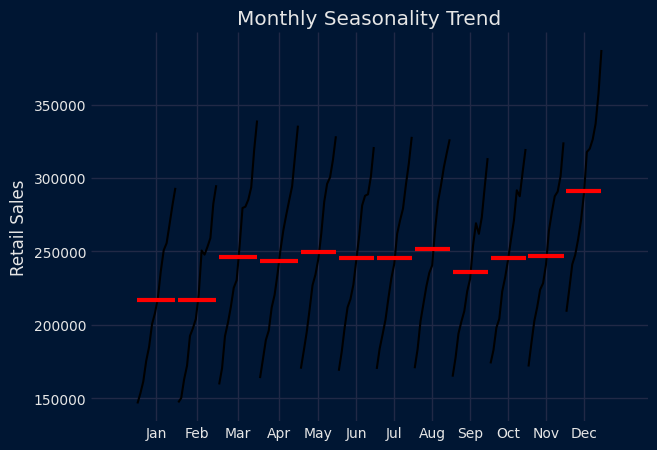

In [ ]:
# plot month for each year and assess trend
month_plot(df['y'],
           ylabel = 'Retail Sales')
plt.title('Monthly Seasonality Trend')
plt.show()

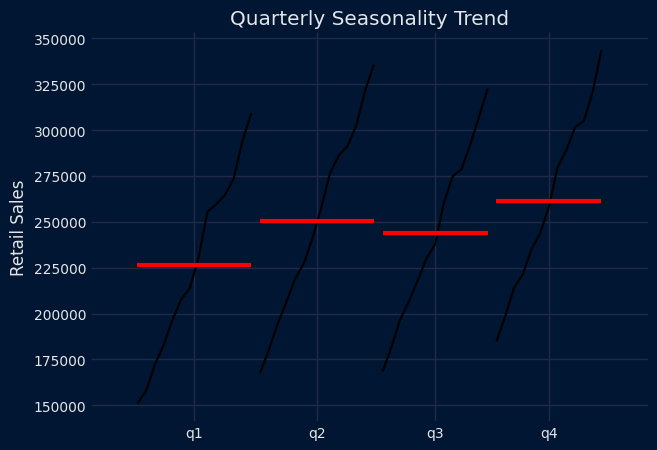

In [ ]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of retail sales
quarter_plot(df['y'].resample('QE').mean(),
           ylabel = 'Retail Sales')
plt.title('Quarterly Seasonality Trend')
plt.show()

# Assess Autocorrelation

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.

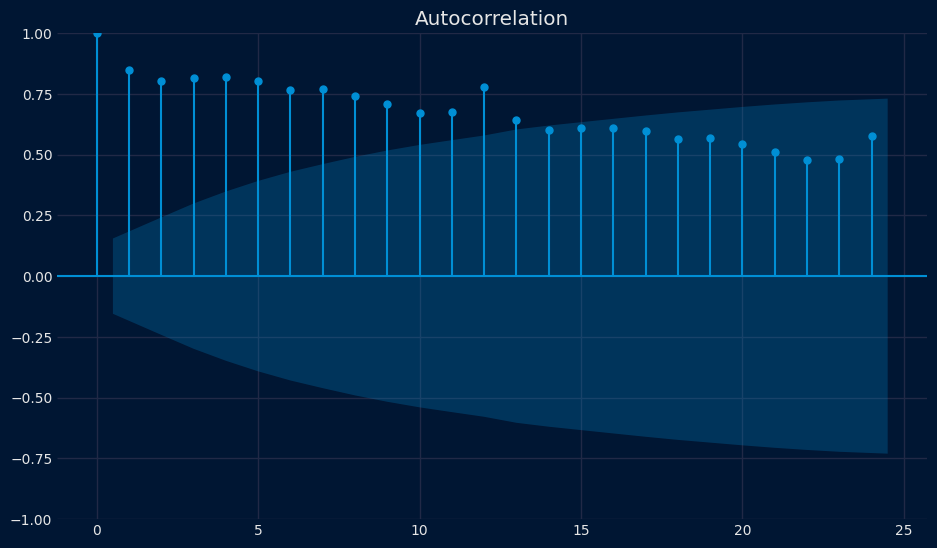

In [ ]:
# Plot the autocorrelation (ACF) of retail sales
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 24, ax = ax)
plt.show()

# Partial Autocorrelation

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

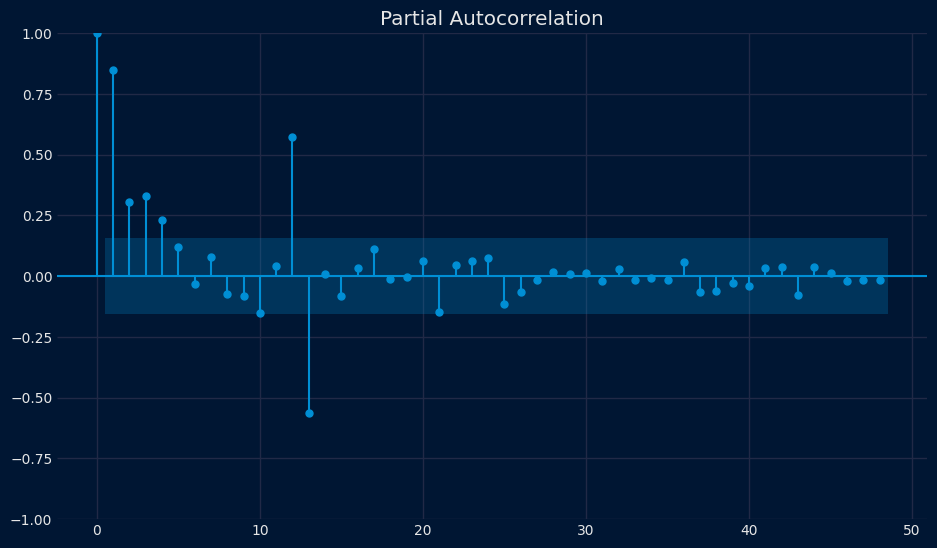

In [ ]:
# Plot the partial autocorrelation (PACF) of retail sales
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 48, ax = ax)
plt.show()

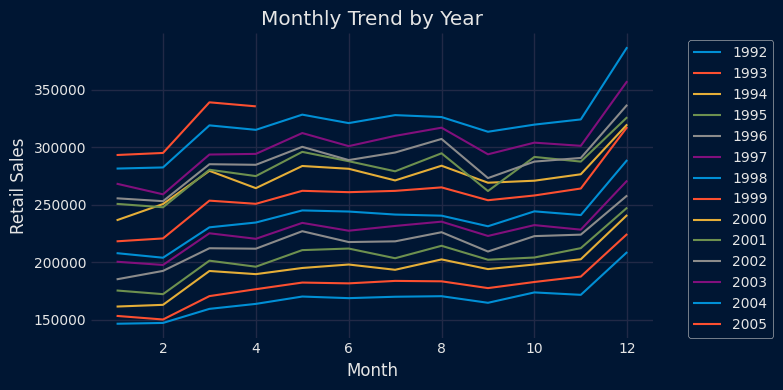

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

for year in df.index.year.unique():
    # Slice that year
    data_year = df.loc[str(year)]

    # Plot by month (x-axis = month only)
    ax.plot(data_year.index.month, data_year.values, label=str(year))

ax.set_title("Monthly Trend by Year")
ax.set_xlabel("Month")
ax.set_ylabel("Retail Sales")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Data Splitting

In [ ]:
# Split into train and test

end_train = pd.Timestamp("2002-12-01")

X_train = df.loc[:end_train]
X_test  = df.loc[end_train + pd.DateOffset(months=1):] # test starts 1 month after '2003-01-01'

In [ ]:
print(X_train.shape)
X_train.index

(132, 1)


DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', name='ds', length=132, freq='MS')

In [ ]:
print(X_test.shape)
X_test.index

(28, 1)


DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01',
               '2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01',
               '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01'],
              dtype='datetime64[ns]', name='ds', freq='MS')

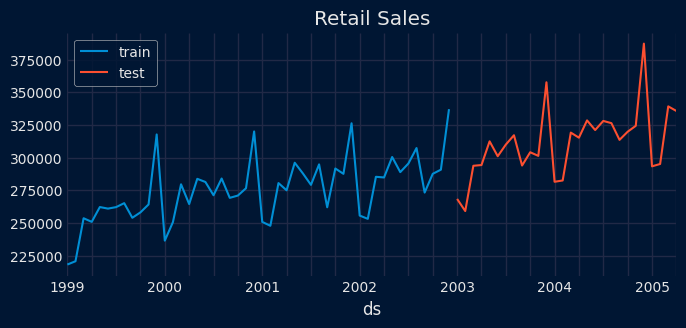

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
X_train.tail(48).plot(ax=ax)
X_test.head(28).plot(ax=ax)
ax.set_title('Retail Sales')
ax.legend(["train", "test"])
plt.show()

---

# Feature Engineering

In [ ]:
# create datetime features: year, quarter, month
from feature_engine.datetime import DatetimeFeatures
# Feature engine's transformer to create datetime
# features can extract features from one or more columns
# or from the index.

# To be compatible with skforecast, we need to extract
# features from a column, and ensure the result does not contain
# any variables that we do not want as part of the forecast.

datetime_transformer = DatetimeFeatures(
    features_to_extract = ["quarter", "month"], # ["year", "quarter", "month"]
    drop_original=True,
)

In [ ]:
# the input to the datetime features

X_train_datetime_df = pd.DataFrame(
    X_train.index,
    index=X_train.index,
)

# the index needs to match with the series we
# want to forecast

X_train_datetime_df

,ds
ds,
1992-01-01,1992-01-01
1992-02-01,1992-02-01
1992-03-01,1992-03-01
1992-04-01,1992-04-01
1992-05-01,1992-05-01
...,...
2002-08-01,2002-08-01
2002-09-01,2002-09-01
2002-10-01,2002-10-01


In [ ]:
# check fit and transform output
datetime_transformer.fit_transform(X_train_datetime_df)

,ds_quarter,ds_month
ds,,
1992-01-01,1,1
1992-02-01,1,2
1992-03-01,1,3
1992-04-01,2,4
1992-05-01,2,5
...,...,...
2002-08-01,3,8
2002-09-01,3,9
2002-10-01,4,10


# Model Fitting

In [ ]:
model = lgb.LGBMRegressor(max_depth=7, n_estimators=1000, random_state=42, verbose=-1)

# model = Pipeline([
#     ("scaler", MinMaxScaler()), # features need to be scaled for Lasso regression
#     ("lasso", Lasso(random_state=9, alpha=10))
# ])

In [ ]:
window_features = RollingFeatures(
                      stats        = ['mean'],
                      window_sizes = [12]
                  )

forecaster = ForecasterRecursive(
    regressor=model,            # the machine learning model
    lags= 12,         # the lag features to create [1, 3, 6, 12]
    window_features=window_features, # the window features to create
    transformer_exog=datetime_transformer, # the datetime features to create
    forecaster_id="recursive",
)

# fit the forecaster
forecaster.fit(y=X_train["y"],
               exog=X_train_datetime_df,
               store_in_sample_residuals=True) # to obtain prediction intervals later

# forecaster.fit(y=X_train["y"])

# print
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: ['roll_mean_12'] 
Window size: 12 
Series name: y 
Exogenous included: True 
Exogenous names: ds 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['quarter', 'month']) 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-01-01 00:00:00'), Timestamp('2002-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 7,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-09-18 22:26:18 
Last fit date: 2025-09-18 22:26:18 
Skforecast version: 0.17.0 
Python version: 3.12.11 
Forecaster id: recursive

# Model Evaluation: Predict the Next 28 periods (2003 - Apr 2005)

## Create df for X_test time features (year, quarter, month)

In [ ]:
print(len(X_test.index))
X_test.index

28


DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01',
               '2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01',
               '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01'],
              dtype='datetime64[ns]', name='ds', freq='MS')

In [ ]:
# we need to create the table with datetime from
# which the datetime features will be created

X_test_datetime_df = pd.DataFrame(
    X_test.index,
    index=X_test.index,
)

# this date needs to coincide with the forecasting
# horizon
X_test_datetime_df

,ds
ds,
2003-01-01,2003-01-01
2003-02-01,2003-02-01
2003-03-01,2003-03-01
2003-04-01,2003-04-01
2003-05-01,2003-05-01
2003-06-01,2003-06-01
2003-07-01,2003-07-01
2003-08-01,2003-08-01
2003-09-01,2003-09-01


In [ ]:
# # forecast periods in the test set

predictions = forecaster.predict(
    steps=28,
    exog=X_test_datetime_df,
)

predictions.head()

,pred
2003-01-01,273505.813011
2003-02-01,256228.145595
2003-03-01,285773.537799
2003-04-01,285639.392923
2003-05-01,295993.837227


In [ ]:
X_test.head()

,y
ds,
2003-01-01,268328
2003-02-01,259051
2003-03-01,293693
2003-04-01,294251
2003-05-01,312389


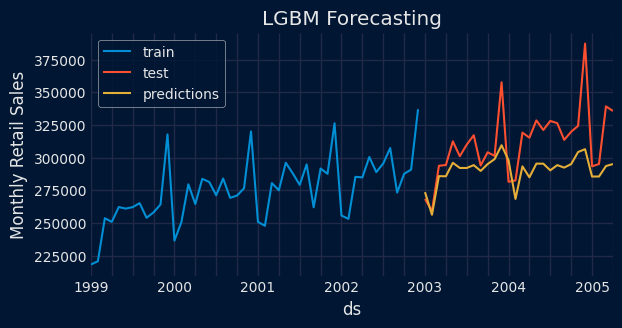

In [ ]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(48)["y"].plot(ax=ax, label='train')
# X_train["y"].plot(ax=ax, label='train')
X_test["y"].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.title("LGBM Forecasting")
plt.ylabel("Monthly Retail Sales")
plt.legend()
plt.show()
ax.legend(bbox_to_anchor=(1.3, 1.0));

# Test Error

In [ ]:
# Prediction error
error_mse = mean_squared_error(
                y_true = X_test["y"],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 783468169.1033666


In [ ]:
# Prediction error
error_rmse = root_mean_squared_error(
                y_true = X_test["y"],
                y_pred = predictions,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 27990.501408573706


# Prediction Intervals

In [ ]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = 28,
                    exog=X_test_datetime_df,
                    interval = [5, 95],
                    method   = 'bootstrapping',
                    n_boot   = 100
             )
predictions.head(3)

,pred,lower_bound,upper_bound
2003-01-01,273505.813011,272418.764332,275278.233155
2003-02-01,256228.145595,252462.701499,258515.427980
2003-03-01,285773.537799,282879.862890,286825.112604


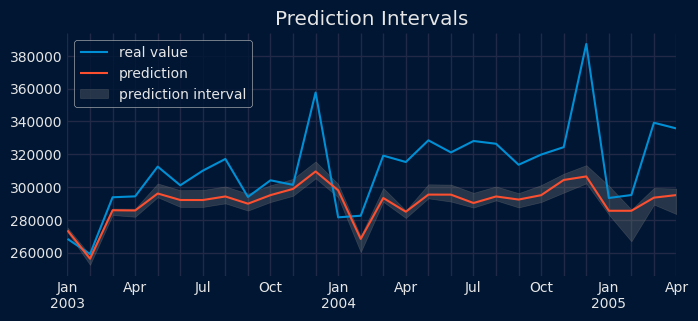

In [ ]:
from skforecast.plot import plot_prediction_intervals, set_dark_theme
set_dark_theme()

fig, ax = plt.subplots(figsize=(7, 3))
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = X_test,
    target_variable     = 'y',
    title               = "Prediction Intervals",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)
ax.legend(loc='upper left');

# X & Y Training Matrices

In [ ]:
X_train_matrix, y_train_matrix = forecaster.create_train_X_y(
                                  y=X_train["y"],
                                  exog=X_train_datetime_df)

In [ ]:
print(X_train_matrix.shape)
X_train_matrix.head()

(120, 15)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,roll_mean_12,ds_quarter,ds_month
ds,,,,,,,,,,,,,,,
1993-01-01,208838.0,171547.0,173655.0,164617.0,170364.0,169890.0,168663.0,170068.0,163669.0,159336.0,147079.0,146376.0,167841.833333,1.0,1.0
1993-02-01,153221.0,208838.0,171547.0,173655.0,164617.0,170364.0,169890.0,168663.0,170068.0,163669.0,159336.0,147079.0,168412.250000,1.0,2.0
1993-03-01,150087.0,153221.0,208838.0,171547.0,173655.0,164617.0,170364.0,169890.0,168663.0,170068.0,163669.0,159336.0,168662.916667,1.0,3.0
1993-04-01,170439.0,150087.0,153221.0,208838.0,171547.0,173655.0,164617.0,170364.0,169890.0,168663.0,170068.0,163669.0,169588.166667,2.0,4.0
1993-05-01,176456.0,170439.0,150087.0,153221.0,208838.0,171547.0,173655.0,164617.0,170364.0,169890.0,168663.0,170068.0,170653.750000,2.0,5.0


In [ ]:
print(y_train_matrix.shape)
y_train_matrix.head()

(120,)


,y
ds,
1993-01-01,153221
1993-02-01,150087
1993-03-01,170439
1993-04-01,176456
1993-05-01,182231


# Forecast 2005 (Jan - Dec)

Notes:
* actuals exist in X_test for Jan 2005 - Apr 2005
* `window_size = 12` therefore we need 12 months of data from the point of prediction
  * Jan 2004 - Dec 2004
* need to create df of exogenous variables for the prediction period: Jan - Dec 2005

In [ ]:

# predict retail sales from Jan 2005 - Dec 2005
start = forecaster.window_size
end = forecaster.window_size - 1
forecast_start = pd.Timestamp('2005-01-01')
feature_start = forecast_start + pd.DateOffset(months = -start)
feature_end = feature_start + pd.DateOffset(months = end)

In [ ]:
print(forecast_start)
print(feature_start)
print(feature_end)
print(forecaster.window_size)
print(start)
print(end)

2005-01-01 00:00:00
2004-01-01 00:00:00
2004-12-01 00:00:00
12
12
11


In [ ]:
X_test.loc[feature_start:feature_end].index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01'],
              dtype='datetime64[ns]', name='ds', freq='MS')

In [ ]:
X_test.loc[forecast_start:].index

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01'], dtype='datetime64[ns]', name='ds', freq='MS')

In [ ]:
# create prediction df for exogneous variables
# Generate a DatetimeIndex for every month start in 2005
prediction_datetimeindex = pd.date_range("2005-01-01", "2005-12-01", freq="MS")
print(prediction_datetimeindex)

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01', '2005-11-01', '2005-12-01'],
              dtype='datetime64[ns]', freq='MS')


In [ ]:
prediction_df_test = pd.DataFrame(
    prediction_datetimeindex,
    columns=["ds"],
    index=prediction_datetimeindex,
)

prediction_df_test

,ds
2005-01-01,2005-01-01
2005-02-01,2005-02-01
2005-03-01,2005-03-01
2005-04-01,2005-04-01
2005-05-01,2005-05-01
2005-06-01,2005-06-01
2005-07-01,2005-07-01
2005-08-01,2005-08-01
2005-09-01,2005-09-01
2005-10-01,2005-10-01


# Prediction 2005 Horizon

In [ ]:
predictions_2005 = forecaster.predict(
    steps=12,
    last_window=X_test.loc[feature_start:feature_end]['y'],
    exog=prediction_df_test,
)

predictions_2005

,pred
2005-01-01,285465.009680
2005-02-01,285465.009680
2005-03-01,293461.708738
2005-04-01,295036.436797
2005-05-01,295325.062007
2005-06-01,295146.831959
2005-07-01,294740.991514
2005-08-01,294617.763450
2005-09-01,292300.207129
2005-10-01,294591.091106


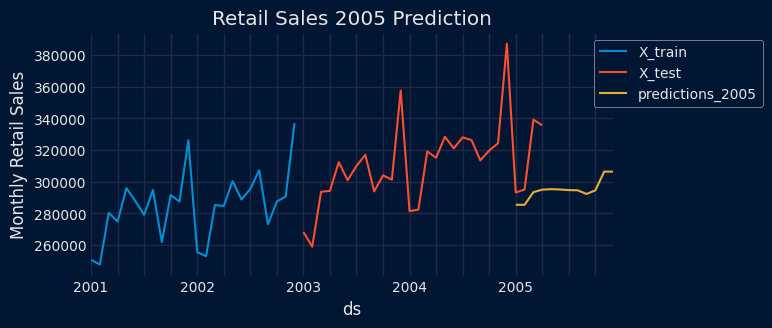

In [ ]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(24)["y"].plot(ax=ax, label='X_train')
X_test['y'].plot(ax=ax, label='X_test')
predictions_2005.plot(ax=ax, label='predictions_2005')
plt.title("Retail Sales 2005 Prediction")
plt.ylabel('Monthly Retail Sales')
ax.legend(bbox_to_anchor=(1.3, 1.0));

# Feature Importances

In [ ]:
forecaster.get_feature_importances().head()

,feature,importance
2,lag_3,395
10,lag_11,356
8,lag_9,318
4,lag_5,304
11,lag_12,289


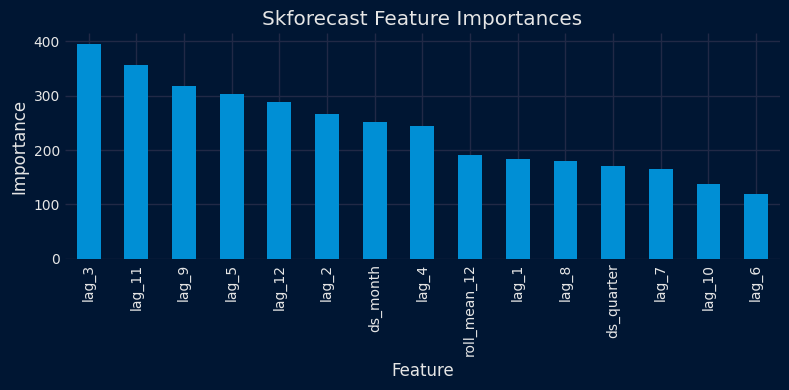

In [ ]:
# Get feature importances (returns a pandas DataFrame)
importances = forecaster.get_feature_importances()

# Plot them
fig, ax = plt.subplots(figsize=(8, 4))
importances.sort_values("importance", ascending=False).plot(
    x="feature", y="importance", kind="bar", ax=ax, legend=False
)

ax.set_title("Skforecast Feature Importances")
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
plt.tight_layout()
plt.show()

---

# Full Training Data Predictions

In [ ]:
predictions_training = forecaster.regressor.predict(X_train_matrix)

In [ ]:
print(X_train_matrix.shape)
print(y_train_matrix.shape)
print(predictions_training.shape)
predictions_training

(120, 15)
(120,)
(120,)


array([156030.25594531, 154930.99783186, 174027.66815806, 178831.1551334 ,
       179540.27836818, 183164.53228182, 183003.88455787, 182766.77183919,
       179987.0485391 , 183130.97605014, 187880.05056324, 222821.59243933,
       158571.54308086, 158733.83747585, 188571.89682885, 186735.34055812,
       196278.83260872, 196260.04268245, 194319.10539922, 202137.0146887 ,
       192496.68567879, 197384.24938884, 202609.53019107, 241069.5251253 ,
       175412.45980928, 173220.93192334, 201989.26960666, 196320.84788873,
       210131.55439641, 211863.23408612, 202964.08600651, 214203.58164901,
       202087.31764284, 204225.55735085, 212351.05702221, 247578.26484572,
       184726.99278433, 191333.88589228, 211721.67736553, 211944.5317666 ,
       226368.81857636, 217874.68597419, 218028.99282412, 226429.81739993,
       209109.08269233, 223158.11778062, 223825.16614254, 258001.33571672,
       200666.38184223, 197776.52963786, 224835.96520759, 220631.37760999,
       234718.93081489, 2

In [ ]:
pd.Series(predictions_training, index=y_train_matrix.index)

,0
ds,
1993-01-01,156030.255945
1993-02-01,154930.997832
1993-03-01,174027.668158
1993-04-01,178831.155133
1993-05-01,179540.278368
...,...
2002-08-01,306788.500837
2002-09-01,273914.562692
2002-10-01,287256.472106


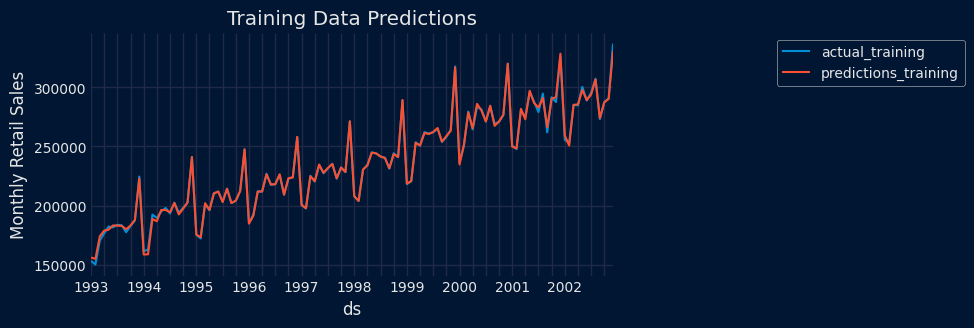

In [ ]:
# Plot the forecast vs the actual

predictions_training = pd.Series(predictions_training, index=y_train_matrix.index)

fig, ax = plt.subplots(figsize=(6, 3))
y_train_matrix.plot(ax=ax, label='actual_training')
predictions_training.plot(ax=ax, label='predictions_training')
plt.title("Training Data Predictions")
plt.ylabel('Monthly Retail Sales')
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [ ]:
error_rmse = root_mean_squared_error(
                y_true = y_train_matrix,
                y_pred = predictions_training,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 1583.5218213292103
